In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json

In [4]:
data_test = pd.read_excel("HW3Avalidate.xlsx") 
data_train = pd.read_excel("HW3Atrain.xlsx")

X_train = data_train.copy()
X_train = X_train.drop('y', axis=1)
Y_train = data_train.copy()
Y_train = Y_train.drop('X_0', axis=1)
Y_train = Y_train.drop('X_1', axis=1)

X_test = data_test.copy()
X_test = X_test.drop('y', axis=1)
Y_test = data_test.copy()
Y_test = Y_test.drop('X_0', axis=1)
Y_test = Y_test.drop('X_1', axis=1)


x_0_min = min(X_train['X_0'])
x_0_max = max(X_train['X_0'])

x_1_min = min(X_train['X_1'])
x_1_max = max(X_train['X_1'])

test_x_0_min = min(X_test['X_0'])
test_x_0_max = max(X_test['X_0'])

test_x_1_min = min(X_test['X_1'])
test_x_1_max = max(X_test['X_1'])

for i in range(len(X_train['X_0'])):
    X_train['X_0'][i] = (X_train['X_0'][i]-x_0_min)/(x_0_max-x_0_min) #formula used for Min-Max
    X_train['X_1'][i] = (X_train['X_1'][i]-x_1_min)/(x_1_max-x_1_min) #formula used for Min-Max
    
for i in range(len(X_test['X_0'])):
    X_test['X_0'][i] = (X_test['X_0'][i]-x_0_min)/(x_0_max-x_0_min) #formula used for Min-Max
    X_test['X_1'][i] = (X_test['X_1'][i]-x_1_min)/(x_1_max-x_1_min) #formula used for Min-Max

training_data = []
for i in range(len(X_train['X_0'])):
    training_data.append(np.array([X_train['X_0'][i],X_train['X_1'][i]]))
    
y_train = []
for i in range(len(X_train['Y'])):
    training_data.append(np.array([X_train['Y'][i]]))
    
testing_data = []
for i in range(len(X_test['X_0'])):
    testing_data.append(np.array([X_test['X_0'][i],X_test['X_1'][i]]))
#print(testing_data)
#print(Y_train)


KeyError: 'Y'

23.67
Accuracy-iteration: 69.51% Learning rate --> 0.00999
22.84
Accuracy-iteration: 69.51% Learning rate --> 0.009980010000000001
21.3
Accuracy-iteration: 86.59% Learning rate --> 0.00997002999
12.3
Accuracy-iteration: 89.02% Learning rate --> 0.00996005996001
10.59
Accuracy-iteration: 87.80% Learning rate --> 0.00995009990004999
9.51
Accuracy-iteration: 85.37% Learning rate --> 0.00994014980014994
8.84
Accuracy-iteration: 85.37% Learning rate --> 0.00993020965034979
8.5
Accuracy-iteration: 85.37% Learning rate --> 0.009920279440699441
8.29
Accuracy-iteration: 85.37% Learning rate --> 0.009910359161258741
8.15
Accuracy-iteration: 85.37% Learning rate --> 0.009900448802097483
8.06
Accuracy-iteration: 85.37% Learning rate --> 0.009890548353295385
8.0
Accuracy-iteration: 85.37% Learning rate --> 0.00988065780494209
7.95
Accuracy-iteration: 85.37% Learning rate --> 0.009870777147137147
7.91
Accuracy-iteration: 85.37% Learning rate --> 0.00986090636999001
7.87
Accuracy-iteration: 85.37% Le

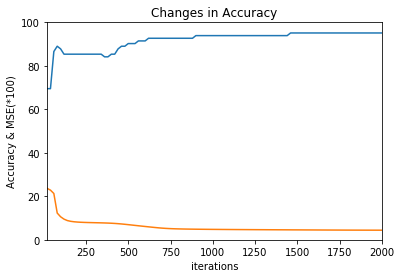

In [15]:
class Network_layer:
    
    def __init__(self, number_input, number_neurons, use_relu):
        #self.size = size
        self.weights = np.random.rand(number_input,number_neurons)
        self.bias = np.zeros(number_neurons)
        self.last_activation = None
        self.use_relu = use_relu
        self.error = None
        self.delta = None
        
    def activate(self, x):
        r = np.dot(x, self.weights) + self.bias
        if self.use_relu:
            self.last_activation = self.relu(r)
        else: 
            self.last_activation = self.sigmoid(r)
            
        return self.last_activation
    
    def relu(self, x):
        #x[x<0] = 0
        
        return np.tanh(x)
                
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def activation_derivative(self, x):
        if self.use_relu:
            #x[x>0] = 1
            #x[x<0] = 0
            return 1.0 - np.tanh(x)**2
        return x * (1 - x)
    

class Neaural_net:
    layers = []
    
    def __init__(self):
        self.layers = []
    
    def add_layer(self, layer):
        self.layers.append(layer)
    
    def feed_forward(self, X):
        for layer in self.layers:
            X = layer.activate(X)
        return X

        
    def backpropagation(self, X, y, learning_rate):
        output = self.feed_forward(X)
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]

            if layer == self.layers[-1]:
                layer.error = y - output
                layer.delta = layer.error * layer.activation_derivative(output)
            else:
                next_layer = self.layers[i + 1]
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error * layer.activation_derivative(layer.last_activation)

        # Update the weights
        for i in range(len(self.layers)):
            layer = self.layers[i]
            input_to_use = np.atleast_2d(X if i == 0 else self.layers[i - 1].last_activation)
            layer.weights += layer.delta * input_to_use.T * learning_rate
            
    def train(self, X, y, learning_rate, max_epochs):
        mses = []

        for i in range(max_epochs):
            for j in range(len(X)):
                self.backpropagation(X[j], y[j], learning_rate)
            if i % 100 == 0:
                mse = np.mean(np.square(y - NN.feed_forward(X)))
                mses.append(mse*100)
                #print('Epoch: #%s, MSE: %f' % (i, float(mse)))

        return mses
    
    def test(self, X, y_true):
        correct = 0
        
        for i in range(len(X)):
            forward_pass = self.feed_forward(X[i])
            if np.around(forward_pass) == y_true[i]:
                correct = correct + 1
        #y_pred = 0
        
        #if forward_pass.ndim == 1:
        #    y_pred = np.argmax(forward_pass)
        #else:
        #    y_pred = np.argmax(forward_pass, axis=1)

#        return (y_pred == y_true).mean()
        return correct/len(X)

data_test = pd.read_excel("HW3Avalidate.xlsx") 
data_train = pd.read_excel("HW3Atrain.xlsx")

X_train = data_train.copy()
X_train = X_train.drop('y', axis=1)
Y_train = data_train.copy()
Y_train = Y_train.drop('X_0', axis=1)
Y_train = Y_train.drop('X_1', axis=1)

X_test = data_test.copy()
X_test = X_test.drop('y', axis=1)
Y_test = data_test.copy()
Y_test = Y_test.drop('X_0', axis=1)
Y_test = Y_test.drop('X_1', axis=1)


x_0_min = min(X_train['X_0'])
x_0_max = max(X_train['X_0'])

x_1_min = min(X_train['X_1'])
x_1_max = max(X_train['X_1'])

test_x_0_min = min(X_test['X_0'])
test_x_0_max = max(X_test['X_0'])

test_x_1_min = min(X_test['X_1'])
test_x_1_max = max(X_test['X_1'])

for i in range(len(X_train['X_0'])):
    X_train['X_0'][i] = (X_train['X_0'][i]-x_0_min)/(x_0_max-x_0_min) #formula used for Min-Max
    X_train['X_1'][i] = (X_train['X_1'][i]-x_1_min)/(x_1_max-x_1_min) #formula used for Min-Max
    
for i in range(len(X_test['X_0'])):
    X_test['X_0'][i] = (X_test['X_0'][i]-x_0_min)/(x_0_max-x_0_min) #formula used for Min-Max
    X_test['X_1'][i] = (X_test['X_1'][i]-x_1_min)/(x_1_max-x_1_min) #formula used for Min-Max

training_data = []
for i in range(len(X_train['X_0'])):
    training_data.append([round(X_train['X_0'][i], 2),round(X_train['X_1'][i],2)])
    
testing_data = []
for i in range(len(X_test['X_0'])):
    testing_data.append([round(X_test['X_0'][i],2),round(X_test['X_1'][i],2)])

y_train = []

for i in range(len(Y_train['y'])):
    y_train.append([Y_train['y'][i]])
    
y_test = []

for i in range(len(Y_test['y'])):
    y_test.append([Y_test['y'][i]])

np_testing_y = np.array(y_test)
np_testing_x = np.array(testing_data)
np_training_x = np.array(training_data)
np_training_y = np.array(y_train)

#print(testing_data)
NN = Neaural_net()
NN.add_layer(Network_layer(2, 10, True))
NN.add_layer(Network_layer(10, 10, True))
NN.add_layer(Network_layer(10,1, True))


# Train the neural networks
accuracy = []
iteration = []
#print(NN.feed_forward(np_training_x[0]))
learning_rate = 0.01
total_error = []
number_test = 100
number_epoc = 20
last_mse = [0,0,0,0,0]
a = 0
for i in range(1,number_test+1):
    errors = NN.train(np_training_x, np_training_y, learning_rate, number_epoc)
    total_error.append(errors)
    learning_rate = learning_rate*0.999
    last_mse[a] = round(errors[0],2)
    print(last_mse[a])
    a = a + 1
    if a > 4:
        a = 0
    iteration.append(i*number_epoc)
    accuracy_one = NN.test(np_testing_x, np_testing_y.flatten())
    print('Accuracy-iteration: %.2f%%' % (accuracy_one*100), "Learning rate --> "+ str(learning_rate))
    accuracy.append(accuracy_one*100)
    mse_same = True
    for i in range(len(last_mse)):
        if round(last_mse[i],2) != round(errors[0],2):
            mse_same = False
    if mse_same:
        print("MSE has converged!")
        break;


plt.plot(iteration,accuracy)
plt.plot(iteration, total_error)
plt.xlabel('iterations')
plt.ylabel('Accuracy & MSE(*100)')
plt.axis((number_epoc,number_epoc*number_test,0,100))
plt.title('Changes in Accuracy')
plt.show()

data = {'weights': []}
data['weights'].append(NN.layers[0].weights.tolist())
data['weights'].append(NN.layers[1].weights.tolist())
data['weights'].append(NN.layers[2].weights.tolist())
with open('data.txt', 'w') as outfile:
    json.dump(data, outfile)
    


In [28]:
a = np.array([1,2])
b = np.array([1,2,3,4,5,6,7,8,9,10])
b = np.random.rand(a.shape[0],10)
print(b.shape)
print(np.dot(a,b))


(2, 10)
[0.92255083 2.05405561 1.53219312 1.75838565 1.26657119 2.05530305
 1.00730676 1.33028476 1.79629828 1.34743652]


In [36]:
X_test = pd.read_excel("HW3Avalidate.xlsx") 
X_train = pd.read_excel("HW3Atrain.xlsx") 

'''
h0 = np.dot(X, weights1) + bias1
phi1 = relu(h0)

h1 = np.dot(phi1, weights2) + bias2
phi2 = relu(h1)

h2 = np.dot(phi2, weights3) + bias3
phi3 = relu(h2)

h3 = np.dot(phi3, weights4) + bias4
phi4 = sigmoid(h3)
'''

print(X_train)

             X_0          X_1  y
0    2917.211242  3289.522533  0
1    1888.937716   781.528356  0
2    4188.521414  1554.476261  0
3    8145.555339  9804.066728  0
4    9584.488981  6176.337189  0
5    4039.633757   167.607143  0
6    2399.020781  6251.891672  1
7    5899.876835  7732.514778  0
8    1832.517788  1300.730270  0
9    1612.288975  6426.781763  1
10   9286.626998  1562.956170  1
11   8497.141947  8806.179833  0
12   9355.215737  9845.547425  0
13   6959.671139  7096.002717  1
14   8318.774203  6561.487762  0
15   2956.353881  1744.414739  0
16   3494.320864  7175.690252  1
17   9733.605268   222.444205  1
18   3357.382654  9136.605932  1
19   1466.794269  7637.730334  0
20   2309.226297  2891.563126  0
21   1640.887579  9801.869658  1
22   5781.556560   248.504846  1
23   3828.052410  2037.851361  0
24    951.195475  2630.862744  0
25   6948.834627  7701.470309  0
26   7196.243632  9244.761921  0
27    848.571206  1321.366007  0
28    513.550491  9111.127856  1
29   3146.

## 1. (10 points) Activation and Loss functions. 
Please choose suitable activation functions φ(0), φ(1), φ(2) and a suitable Loss function to perform the task. Report and justify your choices in the report.

## 2. (10 points) Learning rate, batch size, initialization. 
Please choose a suitable learning rate, batch size, initialization of the parameter values, and any other setting you may need. Discuss and justify your choices in the report.

## 3. (10 points) Training. 
Make plots with the loss function computed over the training set and over the validation set. Stop the training when the error is small enough. Justify your stopping criterium. Report the final accuracy obtained and the confusion matrix on the validation dataset.

## 4. (20 points) Implementation. 
We will run and check the uploaded Python file. To obtain the points for this subproblem, the Python file has to run (no errors) and the MLP model and the Backpropagation algorithm have to be implemented completely from scratch by you. You are not allowed to use any library which implements MLP models, but you are allowed to use auxiliary libraries, e.g. Numpy, Matplotlib, Pandas.

## II. Peer Review paragraph (0 points)
Finally, each group member must write a single paragraph outlining their opinion on the work distri- bution within the group. Did every group member contribute equally? Did you split up tasks in a fair manner, or jointly worked through the exercises. Do you think that some members of your group deserve a different grade from others?